## Summary of the notebook

DropConnnect model trained in the notebook : GBP_CHD_dropconnect_training.ipynb

**train configuration**: <br>
eager execution = disabled 

**process**
1. Load the dropconnect trained model from the path 
2. Pass the trained model loaded in step 1 and the number of samples to be considered (to compute the prediction mean and prediction std) to StochasticRegressor class
3. The StochasticRegressor returns a stochastic model that can yield prediction mean and prediction std 
4. Using this model obtained in 3, we call predict_output() that returns prediction mean, prediction std and the samples from which these mean and std are calculated 
5. Plot these prediction mean and prediction std against gt to check the stochastic behaviour of the model 
6. The code for GBP explanation calculation is adapted to handle the disabled eager execution 
7. For the number of samples, run a loop. Every time the explanation method is called, it returns the explanation (gradients) for that particular sample (of shape (1,8)) and the sample prediction itself (1,1)
8. Using the sample explanation (of shape (1,8)), for say 20 samples of mcdropconnect (yields an explanation matrix of (20, 8)), compute the mean explanation (1,8) and std explanation (1,8). From the 20 sample prediction themselves (20,1) compute the mean prediction (1,1) and std prediction (1,1)

**checks**:
ensure that the layer for which the GBP is being calculated is relevant/correct [should be the last layer]


## Mount the drive

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
print(tf.executing_eagerly())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
False


## Setting the correct path

In [ ]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'dropconnect'

%cd /content/drive/MyDrive/MasterThesis/

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/


## Removing the previous plots and explanations

In [ ]:
import glob, os, os.path
output_plot_path = path+'output_plots/'
filelist_pdf = glob.glob(os.path.join(output_plot_path, '*.pdf'))
filelist_png = glob.glob(os.path.join(output_plot_path, '*.png'))

# removing pdf explanatiosn 
for f in filelist_pdf:
    print(f'removing file {f}')
    os.remove(f)

for f in filelist_png:
    print(f'removing file {f}')
    os.remove(f)

removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/dropconnect_gt_vs_prediction.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/explanation_for_sample_number_0_input_id_1555.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/explanation_for_sample_number_1_input_id_1555.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/combined_explanation_of_2_samples_for_input_id_1555.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/feature_name_vs_coefficient_of_variation_1555.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/dropconnect_gt_vs_prediction.png
re

## Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.0
Eager execution enabled : False


## Load data

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])
#print(train_data[0])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class definitions

### StochasticModel & StochasticRegressor

In [ ]:
import numpy as np
import keras.backend as K

import keras

Layer = keras.layers.Layer
Dropout = keras.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output
        self.layers = self.model.layers

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('intermediate samples shape ', samples.shape)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)
        return samples, mean_pred, std_pred 

    def save(self, path):
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

### DropConnect Layer

In [ ]:
import keras.backend as K

Dense = keras.layers.Dense
Conv1D = keras.layers.Conv1D
Conv2D = keras.layers.Conv2D
Conv3D = keras.layers.Conv3D

class DropConnect:
    def __init__(self, prob=0.5, drop_bias=False, noise_shape=None, uses_learning_phase=False):
        self.prob = prob
        self.drop_bias = drop_bias
        self.noise_shape = noise_shape
        self.kernel_noise_shape = None
        self.bias_noise_shape = None

    @property
    def needs_drop(self):
        return 0.0 < self.prob < 1.0

    def replace_tensor(self, tensor_train, tensor_test):
        if self.uses_learning_phase:
            return K.in_train_phase(tensor_train, tensor_test)
        else:
            return tensor_train

    def get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]

        return tuple(noise_shape)

    def get_config(self):
        config = {
            "prob": self.prob,
            "drop_bias": self.drop_bias,
            "noise_shape": self.noise_shape
        }

        return config

class DropConnectDense(DropConnect, Dense):
    def __init__(self, units, prob=0.5, drop_bias=False, noise_shape=None, use_learning_phase = False, **kwargs):
        DropConnect.__init__(self, prob=prob, drop_bias=drop_bias, noise_shape=noise_shape)
        Dense.__init__(self, units, **kwargs)

        if self.needs_drop:
            self.uses_learning_phase = use_learning_phase

    #def __call__(self, units, training=tf.keras.backend.learning_phase, **kwargs):
    #    Layer.__call__(self, units, **kwargs)
    #    print('training phase ', training)
    #    self.use_training_phase = training

    def build(self, input_shape):
        Dense.build(self, input_shape)

        if self.needs_drop:
            dc_kernel = K.dropout(self.kernel, self.prob, self.noise_shape)
            print('dc kernel ', dc_kernel)
            self.kernel = self.replace_tensor(dc_kernel, self.kernel)
            print('Is kernel same? ', (self.kernel==dc_kernel))

            if self.drop_bias:
                dc_bias = K.dropout(self.bias, self.prob, self.noise_shape)
                print('dc bias ', dc_bias)
                self.bias = self.replace_tensor(dc_bias, self.bias)
                print(' bias ', self.bias)

    def get_config(self):
        config_dc = DropConnect.get_config(self)
        config_base = Dense.get_config(self)

        return dict(list(config_dc.items()) + list(config_base.items()))

## Load the saved model

In [ ]:
# error if the custom object containing the stochastic dropconnect model not passed (Unknown layer: StochasticDropout. Please ensure this object is passed to the `custom_objects` argument)

import os
test = os.listdir(path)

for item in test:
    if item.endswith('.h5'):
        print('model name : ', item)
        model = tf.keras.models.load_model(path+item, 
                                           custom_objects={'DropConnectDense':DropConnectDense})

for layer in model.layers:
    print(layer.get_config())
model.summary()

model name :  dropconnect_model_epochs_250_num_samples_20.h5
dc kernel  Tensor("drop_connect_dense/dropout/Mul_1:0", shape=(4, 1), dtype=float32)
Is kernel same?  True
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_2', 'trainable': True, 'dtype': 'float32',

## GT vs prediction plot

In [ ]:
# Analysis of the input 
num_samples = 20
num_of_inputs_to_be_explained = 1
start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)

# MODEL PREDICTION AND PLOTTING 
stochastic_model = StochasticRegressor(model, num_samples)
pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data, num_samples=2)

#pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_input, num_samples=1)


print('pred_samples ', pred_samples)
print('pred mean ', pred_mean)
print('pred std ', pred_std)
print('predicted samples shape : ', pred_samples.shape)
print('predicted mean shape : ', pred_mean.shape)
print('predicted std shape : ', pred_std.shape)

print('unique elements in std : ', np.unique(pred_std))

start_index :  201
test_input shape : (1, 8)
test_input_adj shape : (1, 8, 1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


intermediate samples shape  (2, 3000, 1)
pred_samples  [[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04916154]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.08385218]
  [0.        ]
  [0.        ]]]
pred mean  [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.06650686]
 [0.        ]
 [0.        ]]
pred std  [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.01734532]
 [0.        ]
 [0.        ]]
predicted samples shape :  (2, 3000, 1)
predicted mean shape :  (3000, 1)
predicted std shape :  (3000, 1)
unique elements in std :  [0.00000000e+00 9.95136797e-05 2.01489776e-04 2.08489597e-04
 3.57117504e-04 4.69822437e-04 6.33526593e-04 8.90079886e-04
 9.13850963e-04 1.79363042e-03 1.99091807e-03 2.04982981e-03
 2.07467005e-03 2.16794387e-03 2.24440172e-03 2.28822604e-03
 2.60059536e-03 2.60899216e-03 2.64672935e-03 2.72734091e-03
 2.89963186e-03 3.01852077e-03 3.04324180e-03 3.07025760e-03
 3.16969678e-03 3.17864120e-03 3.21094692e-03 3.3

range(0, 100)


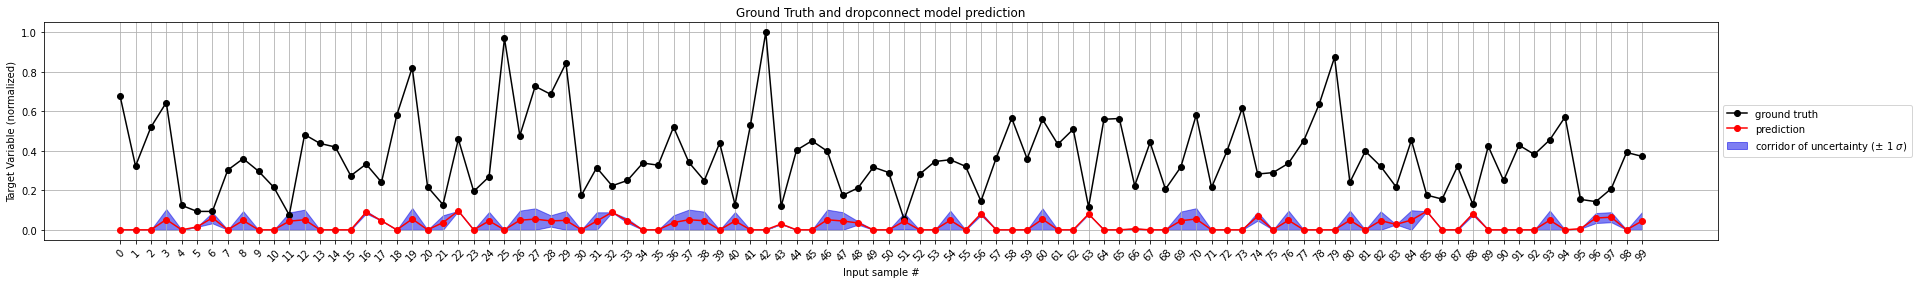

In [ ]:
start_index = np.random.randint(test_data.shape[0]-150)
#random = range(start_index, start_index+100)

#random = range(start_index, start_index+100)
random=range(0, 100)
print(random)
test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_gt_vs_prediction', random, uncert_name)

## Plot explanation code

In [ ]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None):
    plt.figure(figsize=(15, 10))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    print('grads_plot ', list(grads_plot))
    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors) # this code appropriate legend

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names[:-1])

    if err is not None:
        error = plt.plot([], label='corridor of uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        plt.title(f'combined explanation , prediction : {combination_title[0]} $\pm$ {combination_title[1]} , GT : {combination_title[2]}')
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['corridor of uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        plt.legend(handles, labels)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'explanation for sample_number {sample_number}')
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    plt.subplots_adjust()
    plt.savefig(save_file_path+'.pdf')
    plt.savefig(save_file_path+'.png')

## Compute GBP explanation



In [ ]:
# tf1 implementation for GBP 

import numpy as np

import keras
from keras import backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

#Code partially based on https://github.com/eclique/keras-gradcam/blob/master/grad_cam.py

def make_guided_bp_model(model_fn):
    """
        Transform model to have overriden ReLU gradient for guided backpropagation.
        Parameters
        ----------
        model_fn: callable
            Function that builds and returns a model instance    
    """

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = K.get_session().graph
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        gbp_model = model_fn

    return gbp_model

def guided_bp(input_image, gbp_model, layer_name, output_idx=-1):
    """
        Performs guided backpropagation saliency computation.
        Parameters
        ----------
        input_image: numpy array
            Image to compute saliency
        gbp_model: keras.models.Model
            Keras model with overriden gradient, see make_guided_bp_model
        layer_name: str
            Name of the layer to compute gradients
        output_idx: int
            Index of the output neuron to compute gradients, defaults to use whole output vector
    """

    inp = gbp_model.input
    print('inp shape ', inp.shape)
    outp = gbp_model.get_layer(layer_name).output
    print('outp ', outp)
    print('type outp ', type(outp))
    print('outp shape ', outp.shape)
    
    if output_idx > 0:
        outp = outp[:, output_idx]

    gradient = K.gradients(outp, inp)[0]
    grad_fn = K.function([inp, K.learning_phase()], [gradient])
    grads_val = grad_fn([input_image, 0])[0]

    output_fn = K.function([inp], [outp])
    output = output_fn([input_image])

    print('output ', output)
    print('type output ', type(output))

    print('prediction \n', output)
    print('prediction shape ', output[0].shape)
    return grads_val, output

In [ ]:
# Analysis of the input 
test_sample_index=np.random.randint(3000)
test_input_temp = test_data[test_sample_index]
ground_truth = test_labels[test_sample_index]
test_input = np.expand_dims(test_input_temp, axis=0)
print('test_input :', test_input)
print('ground_truth : ', ground_truth)
print('feature_name : ', feature_names)

stochastic_model.summary()

test_input : [[0.22291022 0.47115385 0.84313725 0.01931415 0.03082887 0.02682313
  0.02780032 0.04519248]]
ground_truth :  [0.47643879]
feature_name :  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 drop_connect_dense 

gbp_model layers : 
layer name  dense
layer name  dense_1
layer name  dense_2
layer name  dense_3
layer name  drop_connect_dense
inp shape  (None, 8)
outp  Tensor("drop_connect_dense/Relu:0", shape=(None, 1), dtype=float32)
type outp  <class 'tensorflow.python.framework.ops.Tensor'>
outp shape  (None, 1)
output  [array([[0.]], dtype=float32)]
type output  <class 'list'>
prediction 
 [array([[0.]], dtype=float32)]
prediction shape  (1, 1)
grads_plot  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
inp shape  (None, 8)
outp  Tensor("drop_connect_dense/Relu:0", shape=(None, 1), dtype=float32)
type outp  <class 'tensorflow.python.framework.ops.Tensor'>
outp shape  (None, 1)
output  [array([[0.]], dtype=float32)]
type output  <class 'list'>
prediction 
 [array([[0.]], dtype=float32)]
prediction shape  (1, 1)
grads_plot  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


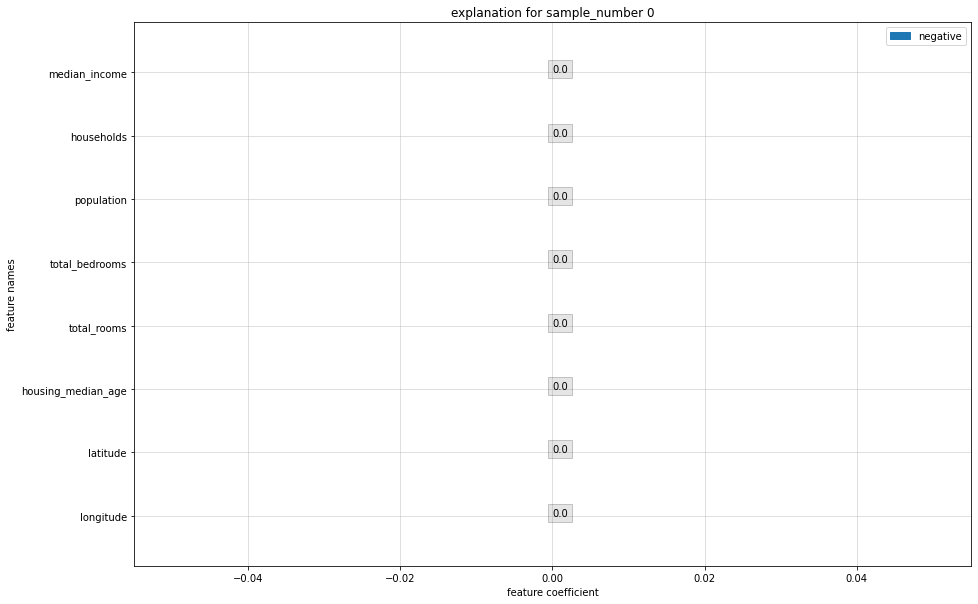

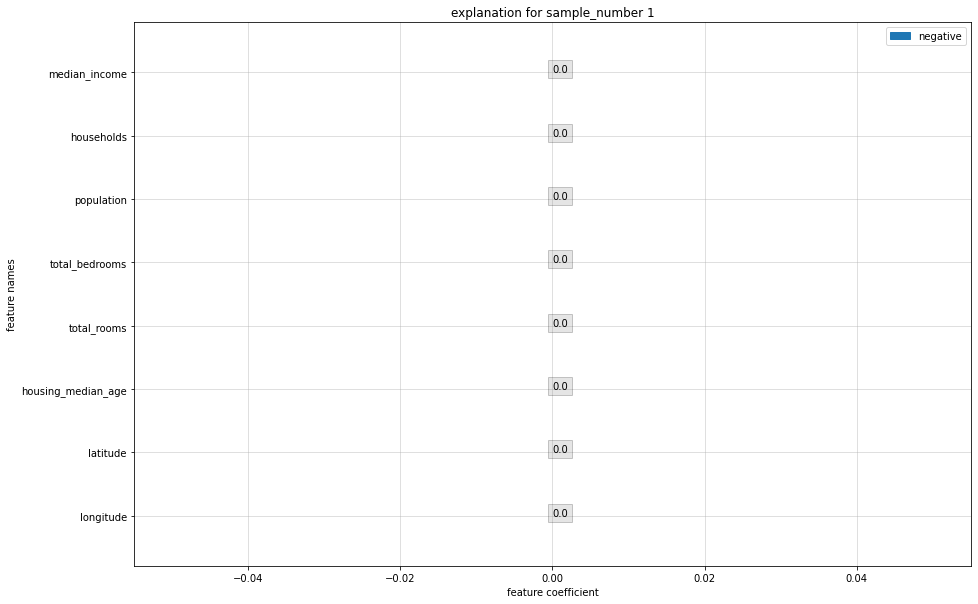

In [ ]:
num_samples_explanations_to_be_generated = 2

gbp_model = make_guided_bp_model(stochastic_model)
gbp_exp = []
component_output = []

print('gbp_model layers : ')
for i in gbp_model.layers:
    print('layer name ', i.name)


for i in range(num_samples_explanations_to_be_generated):
    sample_exp, sample_outp = guided_bp(test_input, stochastic_model, 'drop_connect_dense')
    gbp_exp.append(sample_exp)
    component_output.append(sample_outp)
    plot_explanation(sample_exp.squeeze(axis=0),  # pass samples_explanation as list rather than a np array
                     feature_names, 
                     sample_number=i, 
                     err=None, 
                     save_file_path=path+'output_plots/explanation_for_sample_number_'+str(i)+'_input_id_'+str(test_sample_index),
                     combination_title=None)

(2, 8)
gbp exp 
  [array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]
mean exp 
  [0. 0. 0. 0. 0. 0. 0. 0.]
std exp 
  [0. 0. 0. 0. 0. 0. 0. 0.]
feature names :
   ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
component_output 
 [[array([[0.]], dtype=float32)], [array([[0.]], dtype=float32)]]
component_output shape : 
 2
mean_of_predictions 
  [0.]
std_of_prediction 
  [0.]
grads_plot  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


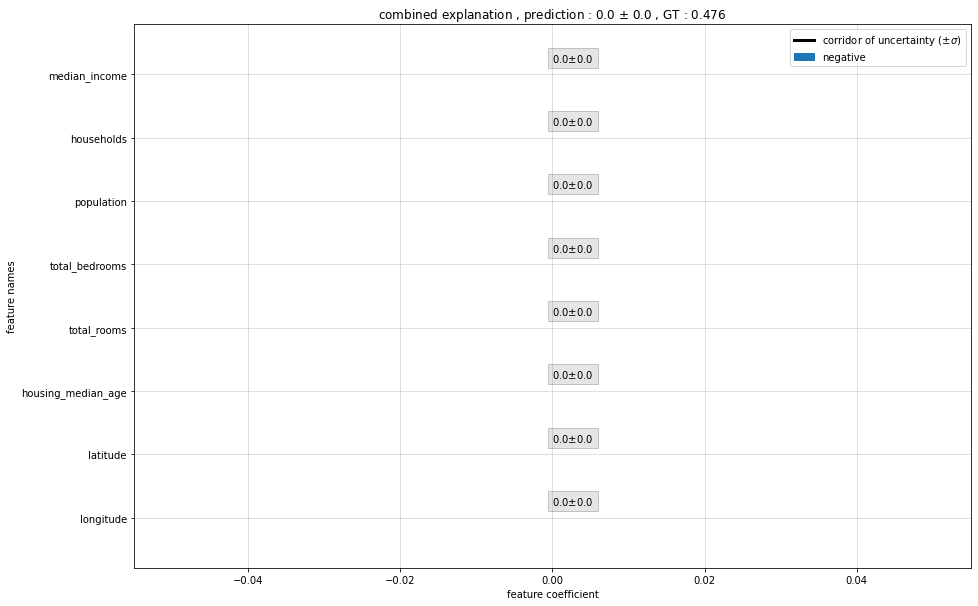

In [ ]:
gbp_exp_arr_temp = np.array(gbp_exp)
gbp_exp_arr = np.reshape(gbp_exp_arr_temp, (-1, 8))
print(gbp_exp_arr.shape)

print('gbp exp \n ', gbp_exp)
mean_of_feature_exp = np.mean(gbp_exp_arr, axis=0)
std_of_feature_exp = np.std(gbp_exp_arr, axis=0) 

print('mean exp \n ', mean_of_feature_exp)
print('std exp \n ', std_of_feature_exp)

print('feature names :\n  ', feature_names)

component_output_arr_temp = np.array(component_output)
component_output_arr = np.reshape(component_output_arr_temp, (-1, 1))

print('component_output \n', component_output)
print('component_output shape : \n', len(component_output))

mean_of_predictions = np.mean(component_output_arr, axis=0)
std_of_predictions = np.std(component_output_arr, axis=0)

print('mean_of_predictions \n ', mean_of_predictions)
print('std_of_prediction \n ', std_of_predictions)

mean_of_predictions = str(round(float(mean_of_predictions), 3))
std_of_predictions = str(round(float(std_of_predictions), 3))
ground_truth = str(round(float(ground_truth), 3))

plot_explanation(mean_of_feature_exp,  # pass explanation as list 
                 feature_names, 
                 sample_number=i, 
                 err=std_of_feature_exp, 
                 save_file_path=path+'output_plots/combined_explanation_of_'+str(component_output_arr.shape[0])+'_samples_for_input_id_'+str(test_sample_index),
                 combination_title=[mean_of_predictions, std_of_predictions, ground_truth])

## Coefficient of Variation

mean_feature_weight  [0. 0. 0. 0. 0. 0. 0. 0.]
std_feature_weight  [0. 0. 0. 0. 0. 0. 0. 0.]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
coefficient_of_variation  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


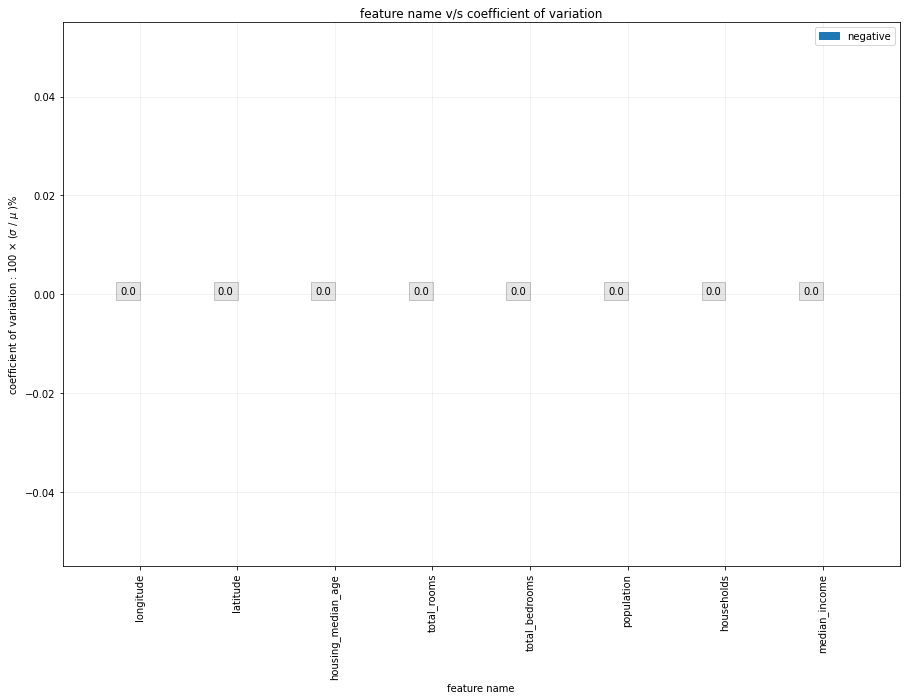

In [ ]:
# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) 
# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]
# https://en.wikipedia.org/wiki/Coefficient_of_variation
# https://www.formpl.us/blog/coefficient-variation

print('mean_feature_weight ', mean_of_feature_exp)
print('std_feature_weight ', std_of_feature_exp)
print('feature_names ', feature_names)

eps=1e-3
# compute coefficient of variation 
coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(std_of_feature_exp, mean_of_feature_exp)]
print('coefficient_of_variation ', coefficient_of_variation)


plt.figure(figsize=(15, 10))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label

plt.bar(feature_names[:-1], coefficient_of_variation, color=colors)
# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : 100 $\times$ ($\sigma$ / $\mu$ )%')
plt.grid(alpha=0.2) 


plt.legend(handles, labels)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i - 0.2, v, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.pdf', bbox_inches='tight')
plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.png', bbox_inches='tight')

#https://en.wikipedia.org/wiki/Kurtosis

In [ ]:
# colab support not yet provided 
#!pip install stickyland